# **Predicción de retrasos de vuelos**
Entrega # 1
---


## Introducción
El análisis de los retrasos en vuelos es un problema clave en la industria de la aviación, ya que los retrasos pueden generar importantes costos operativos y afectar la satisfacción del cliente. Este notebook se enfoca en desarrollar **modelos predictivos** para los retrasos en vuelos de diversas aerolíneas durante el año 2015, con el objetivo de entender mejor los factores que influyen en estos retrasos y proponer soluciones para anticipar dichos problemas.

El conjunto de datos proviene de un registro histórico de vuelos, que incluye información detallada sobre los horarios programados, aeropuertos de origen y destino, así como las aerolíneas involucradas. A lo largo de este análisis, se implementan **tres modelos distintos** para explorar cómo diferentes variables, como el aeropuerto de origen, la aerolínea y el destino, afectan los retrasos:

**Modelo nº1:** Se enfoca en una sola aerolínea y un solo aeropuerto de origen. El objetivo es obtener un modelo básico que considere solo las operaciones de una aerolínea en un aeropuerto específico.

**Modelo nº2:** Este modelo amplía el análisis a todas las operaciones de una aerolínea en varios aeropuertos. La idea es mejorar la precisión prediciendo retrasos a través de múltiples aeropuertos.

**Modelo nº3:** Se incluye tanto la hora de salida como la de llegada, considerando las interacciones entre aeropuertos de origen y destino, lo que permite capturar de manera más precisa los retrasos que pueden ocurrir en rutas específicas.

**Enfoque Actual:**
Se ha decidido concentrar el análisis en el Modelo nº3, ya que ofrece una visión más detallada y completa sobre los factores que afectan los retrasos en vuelos, aprovechando las interacciones entre aeropuertos y tiempos de vuelo. Los Modelos nº1 y nº2 se dejan sin resolver en esta fase del proyecto, permitiendo que el enfoque se centre en el modelo que proporciona la mayor profundidad analítica para la predicción de retrasos.

## Indice

Este notebook está compuesto por tres partes: limpieza (sección 1), exploración (secciones 2-5) y modelado (sección 6).

**Preámbulo:** visión general del conjunto de datos <br>

**1. Limpieza**
* 1.1 Fechas y horarios <br>

**2. Comparación de aerolíneas**

* 2.1 Descripción estadística básica de las aerolíneas
* 2.2 Distribución de los retrasos: estableciendo el ranking de aerolíneas <br>

**3. Retrasos: ¿despegue o aterrizaje?** <br>

**4. Relación entre el aeropuerto de origen y los retrasos** <br>

* 4.1 Área geográfica cubierta por las aerolíneas <br>
* 4.2 Cómo el aeropuerto de origen impacta los retrasos <br>
* 4.3 ¿Vuelos con retrasos habituales? <br>

**5. Variabilidad temporal de los retrasos** <br>

**6. Predicción de retrasos en vuelos** <br>
* 6.1 Modelo nº1: una aerolínea, un aeropuerto
** 6.1.1 Problemas
* 6.2 Modelo nº2: una aerolínea, todos los aeropuertos
* 6.3 Modelo nº3: Teniendo en cuenta los destinos

**Conclusión**


___
## _Preámbulo_: visión general del conjunto de datos


Primero, cargamos todos los paquetes que se necesitarán durante este proyecto:

In [1]:
!pip install basemap
!pip install gdown

In [2]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
import gdown
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

y luego, leemos el archivo que contiene los detalles de todos los vuelos que ocurrieron en 2015. Mostramos alguna información relacionada con los tipos de variables en el DataFrame y la cantidad de valores nulos para cada variable:

In [3]:
url = 'https://drive.google.com/uc?id=1VelgkDMLG9O3s2NopN6QE3qJzxx4L0ga&export=download'

# Descargar el archivo CSV
output = 'flights.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output, low_memory=False)
print('Dataframe dimensions:', df.shape)

# Proporciona información sobre los tipos de columnas y la cantidad de valores nulos.
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'column type'})

# Concatena la información
tab_info = pd.concat([tab_info,
                      pd.DataFrame(df.isnull().sum()).T.rename(index={0: 'null values (nb)'}),
                      pd.DataFrame((df.isnull().sum() / df.shape[0]) * 100).T.rename(index={0: 'null values (%)'})])

tab_info


Downloading...
From (original): https://drive.google.com/uc?id=1VelgkDMLG9O3s2NopN6QE3qJzxx4L0ga&export=download
From (redirected): https://drive.google.com/uc?id=1VelgkDMLG9O3s2NopN6QE3qJzxx4L0ga&export=download&confirm=t&uuid=fb024986-2fcc-4261-9f92-8e173ac096ae
To: /content/flights.csv
100%|██████████| 592M/592M [00:07<00:00, 80.1MB/s]


Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


In [4]:
df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,2355.0,-4.0,22.0,17.0,320.0,298.0,272.0,2611,749.0,4.0,819,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,2355.0,-4.0,17.0,12.0,227.0,215.0,195.0,1617,427.0,3.0,446,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,2350.0,-9.0,17.0,7.0,221.0,222.0,197.0,1598,424.0,8.0,440,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,2353.0,-6.0,10.0,3.0,161.0,157.0,144.0,1189,327.0,3.0,340,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Cada registro del archivo flights.csv corresponde a un vuelo, y vemos que se han registrado más de 5'800'000 vuelos en 2015. Estos vuelos están descritos según 31 variables. En este notebook utilizaremos las siguientes variables para nuestro modelo:

- **YEAR, MONTH, DAY, DAY_OF_WEEK:** fechas del vuelo <br/>
- **AIRLINE**: un número de identificación asignado por el DOT de EE.UU. para identificar una aerolínea única <br/>
- **ORIGIN_AIRPORT** y **DESTINATION_AIRPORT**: código atribuido por la IATA para identificar los aeropuertos <br/>
- **SCHEDULED_DEPARTURE** y **SCHEDULED_ARRIVAL** : horarios programados de despegue y aterrizaje <br/>
- **DEPARTURE_TIME** y **ARRIVAL_TIME**: horarios reales en los que tuvieron lugar el despegue y el aterrizaje <br/>
- **DEPARTURE_DELAY** and **ARRIVAL_DELAY**: diferencia (en minutos) entre los horarios planificados y reales <br/>
- **DISTANCE**: distancia (en millas)  <br/>

Un archivo adicional de este conjunto de datos, el archivo airports.csv, ofrece una descripción más exhaustiva de los aeropuertos.

In [5]:
url = 'https://drive.google.com/uc?id=16m4zG4-3UnUmerJIDYgP0SE2ebS7VNrI&export=download'
# Descargar el archivo CSV
output = 'airports.csv'
gdown.download(url, output, quiet=False)

airports = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=16m4zG4-3UnUmerJIDYgP0SE2ebS7VNrI&export=download
To: /content/airports.csv
100%|██████████| 23.9k/23.9k [00:00<00:00, 39.0MB/s]


In [6]:
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


Para tener una visión global del área geográfica cubierta en este conjunto de datos, podemos graficar la ubicación de los aeropuertos e indicar el número de vuelos registrados durante el año 2015 en cada uno de ellos:

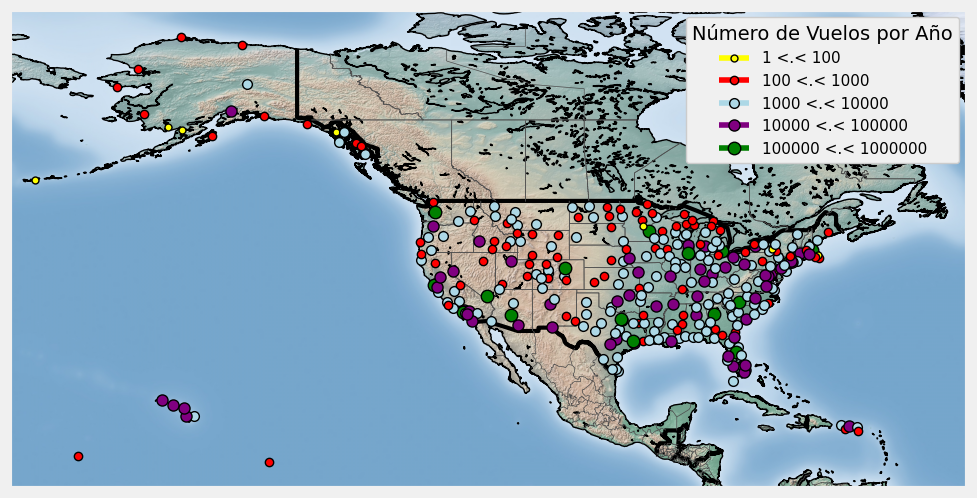

In [7]:
#ESTE CODIGO ES SOLO PARA GENERAR EL MAPA, NO ES NECESARIO CORRERLO NUEVAMENTE

count_flights = df['ORIGIN_AIRPORT'].value_counts()
#___________________________
plt.figure(figsize=(11,11))
#________________________________________
# Define las propiedades de los marcadores y etiquetas.
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# Coloca los aeropuertos en el mapa.
for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
#_____________________________________________
#Elimina las etiquetas duplicadas y establece su orden.
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Número de Vuelos por Año', frameon = True, framealpha = 1)
plt.show()

Dado el gran tamaño del conjunto de datos, decidimos considerar solo un subconjunto de los datos para reducir el tiempo de cálculo. Solo mantendremos los vuelos de enero de 2015:

In [8]:
df = df[df['MONTH'] == 1]

___
# 1. Limpieza
___
### 1.1 Fechas y horas

En el DataFrame inicial, las fechas están codificadas según 4 variables: **YEAR, MONTH, DAY y DAY_OF_WEEK**. De hecho, Python ofrece el formato datetime que es muy conveniente para trabajar con fechas y horas, por lo que convertimos las fechas a este formato:


In [9]:
df[['YEAR','MONTH', 'DAY', 'DAY_OF_WEEK']]

,YEAR,MONTH,DAY,DAY_OF_WEEK
0,2015,1,1,4
1,2015,1,1,4
2,2015,1,1,4
3,2015,1,1,4
4,2015,1,1,4
...,...,...,...,...
469963,2015,1,31,6
469964,2015,1,31,6
469965,2015,1,31,6
469966,2015,1,31,6


In [10]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

Además, en la variable **SCHEDULED_DEPARTURE**, la hora del despegue está codificada como un flotante donde los dos primeros dígitos indican la hora y los dos últimos, los minutos. Este formato no es conveniente, por lo que convertiremos también. Finalmente, fusionamos la hora de despegue con la fecha del vuelo. Para realizar estas transformaciones, definimos algunas funciones:

In [11]:
df[['SCHEDULED_DEPARTURE']]

,SCHEDULED_DEPARTURE
0,5
1,10
2,20
3,20
4,25
...,...
469963,2359
469964,2359
469965,2359
469966,2359


In [12]:
#_________________________________________________________
# Función que convierte 'HHMM' string a datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Funcion que combina la fecha y hora a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Función que combina 2 columnas del dataframe para crear el formato datatime

def create_flight_time(df, col):
    liste = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

las llamamos para aplicar los cambios en el dataframe:

In [13]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


Notemos que en la práctica, el contenido de las variables **DEPARTURE_TIME** y **ARRIVAL_TIME** puede ser un poco engañoso ya que no contienen las fechas. Por ejemplo, en la primera entrada del DataFrame, el despegue programado es a las 00:05 del 1 de enero. La variable **DEPARTURE_TIME** indica 23:54, por lo que no sabemos si el vuelo salió antes del horario programado o si hubo un gran retraso. Por lo tanto, las variables DEPARTURE_DELAY y ARRIVAL_DELAY son más útiles, ya que proporcionan directamente los retrasos en minutos. Por lo tanto, en lo que sigue, no utilizaremos las variables **DEPARTURE_TIME** y **ARRIVAL_TIME**.


Finalmente, limpiamos el DataFrame eliminando las variables que no utilizaremos y reorganizamos las columnas para facilitar su lectura:

In [14]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR',
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


Hasta este punto, revisaremos qué tan completo está nuestro dataframe:

In [15]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


Observamos que el factor de llenado de las variables es bastante alto (> 97%). Dado que el objetivo principal de esta entrega no es lograr la mejor precisión posible en la predicción de retrasos de vuelos, sino un análisis exhaustivo, decidimos continuar sin intentar imputar los valores faltantes, y simplemente eliminamos las entradas que contienen datos nulos.

In [16]:
df.dropna(inplace = True)

___
## 2. Comparando aerolíneas


Como se mencionó anteriormente, la variable **AIRLINE** contiene las abreviaturas de las aerolíneas. Sus nombres completos se pueden obtener del archivo airlines.csv.

In [17]:
import gdown

# URL del archivo en Google Drive
url = 'https://drive.google.com/uc?id=13hIx-JZGDuPnNNBe18hZtoRW2V3S0gHT&export=download'

# Descargar el archivo CSV
output = 'airlines.csv'
gdown.download(url, output, quiet=False)


airlines_names = pd.read_csv(output)
airlines_names

Downloading...
From: https://drive.google.com/uc?id=13hIx-JZGDuPnNNBe18hZtoRW2V3S0gHT&export=download
To: /content/airlines.csv
100%|██████████| 359/359 [00:00<00:00, 1.15MB/s]


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


Para su uso futuro, colocamos el contenido de este DataFrame en un diccionario:

In [18]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

___
### 2.1 Descripción estadística básica de las aerolíneas

Como primer paso, consideramos todos los vuelos de todas las aerolíneas. Aquí, el objetivo es clasificar las aerolíneas en función de su puntualidad y para ello, calculamos algunos parámetros estadísticos básicos:

In [19]:
#__________________________________________________________________
# función que extrae los parámetros estadísticos de un objeto group
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creación del dataframe con la información estadística de cada aerolínea:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


Para facilitar la lectura de esta información, construimos los siguientes gráficos

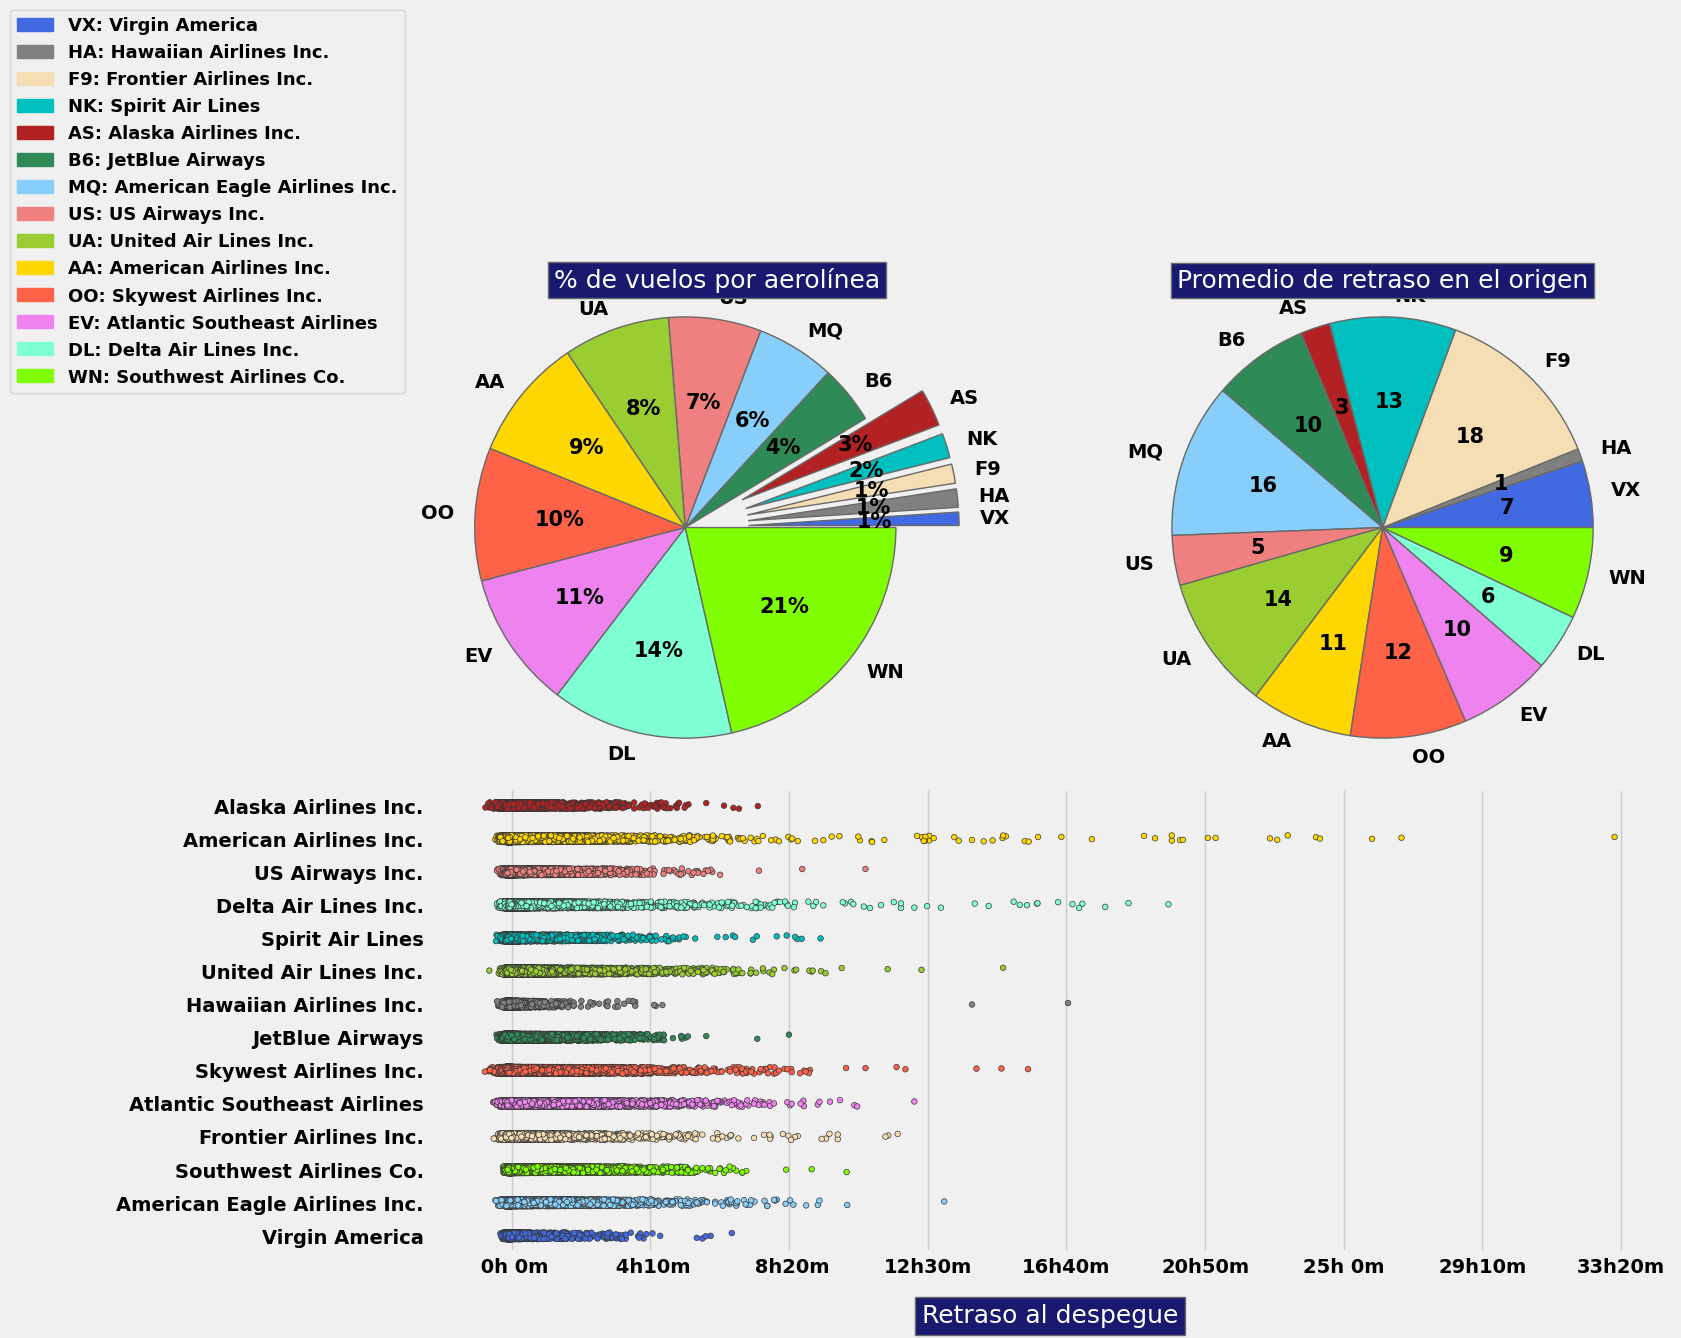

In [20]:
font = {'family' : 'sans-serif', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# Extraemos un subconjunto de columnas y redefinimos las etiquetas de las aerolíneas

df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[1,:])
#------------------------------
# Gráfico cirular nº1: numero de vuelos
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)):
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% de vuelos por aerolínea', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# Establecimos la leyenda: abreviatura -> nombre de la aerolínea.
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9),
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Gráfico cirular nº1: promedio de retraso al despegue
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)):
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Promedio de retraso en el origen', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# Gráfico de tiras con todos los valores reportados para los retrasos
#___________________________________________________________________
# Redefinimos los colores para que coincidan con los gráficos circulares
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Retraso al despegue', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)

Considerando el primer gráfico circular que muestra el porcentaje de vuelos por aerolínea, vemos que hay cierta disparidad entre las aerolíneas. Por ejemplo, Southwest Airlines representa aproximadamente el 20% de los vuelos, lo cual es similar al número de vuelos operados por las 7 aerolíneas más pequeñas. Sin embargo, si observamos el segundo gráfico circular, vemos que, por el contrario, las diferencias entre las aerolíneas son menos pronunciadas. Excluyendo a Hawaiian Airlines y Alaska Airlines, que reportan retrasos medios extremadamente bajos, obtenemos que un valor de aproximadamente 11 ± 7 minutos representaría correctamente todos los retrasos medios. Cabe señalar que este valor es bastante bajo, lo que significa que el estándar para cada aerolínea es respetar el horario programado.

Finalmente, la figura en la parte inferior hace un censo de todos los retrasos que se midieron en enero de 2015. Esta representación da una idea de la dispersión de los datos y pone en perspectiva la relativa homogeneidad que apareció en el segundo gráfico circular. De hecho, vemos que, aunque todos los retrasos medios están alrededor de los 10 minutos, este valor bajo es una consecuencia del hecho de que la mayoría de los vuelos despegan a tiempo. Sin embargo, ocasionalmente, podemos enfrentar retrasos realmente grandes que pueden alcanzar varias horas.

La gran mayoría de los retrasos cortos es visible en la siguiente figura:

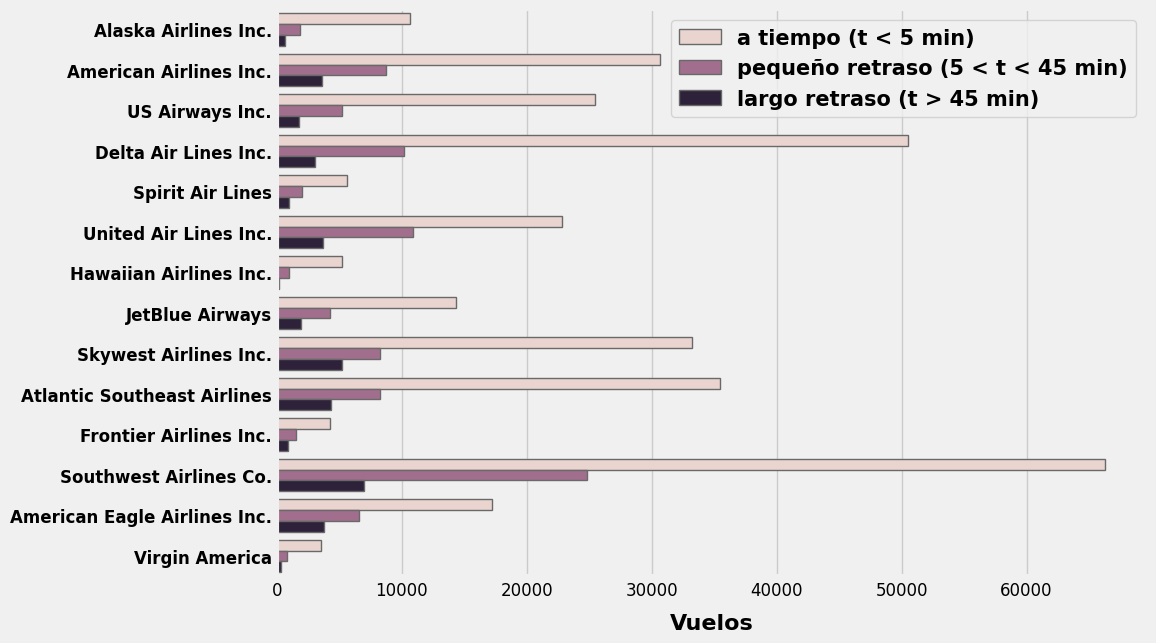

In [21]:
#_____________________________________________
# Función que agrupa los retrasos

delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# Reemplazamos las abreviaciones de las aerolíneas por su nombre completo
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Vuelos', fontsize=16, weight = 'bold', labelpad=10)
#________________
L = plt.legend()
L.get_texts()[0].set_text('a tiempo (t < 5 min)')
L.get_texts()[1].set_text('pequeño retraso (5 < t < 45 min)')
L.get_texts()[2].set_text('largo retraso (t > 45 min)')
plt.show()

Esta figura muestra el conteo de los retrasos de menos de 5 minutos, aquellos en el rango de 5 < t < 45 minutos y, finalmente, los retrasos mayores a 45 minutos. Así, vemos que, independientemente de la aerolínea, los retrasos mayores a 45 minutos solo representan un pequeño porcentaje. Sin embargo, la proporción de retrasos en estos tres grupos depende de la aerolínea. Por ejemplo, en el caso de SkyWest Airlines, los retrasos mayores a 45 minutos son solo un 30% menos frecuentes en comparación con los retrasos en el rango de 5 < t < 45 minutos. Las cosas están mejor para Southwest Airlines, ya que los retrasos mayores a 45 minutos son 4 veces menos frecuentes que los retrasos en el rango de 5 < t < 45 minutos.

### 2.2 Distribución de retrasos: establecimiento del ranking de aerolíneas
Se demostró en la sección anterior que los retrasos medios se comportan de manera homogénea entre las aerolíneas (con la excepción de dos casos extremos) y están alrededor de 11±7 minutos. Luego, vimos que este valor bajo es una consecuencia de la gran proporción de vuelos que despegan a tiempo. Sin embargo, ocasionalmente, se pueden registrar retrasos grandes. En esta sección, examinamos más en detalle la distribución de los retrasos para cada aerolínea:

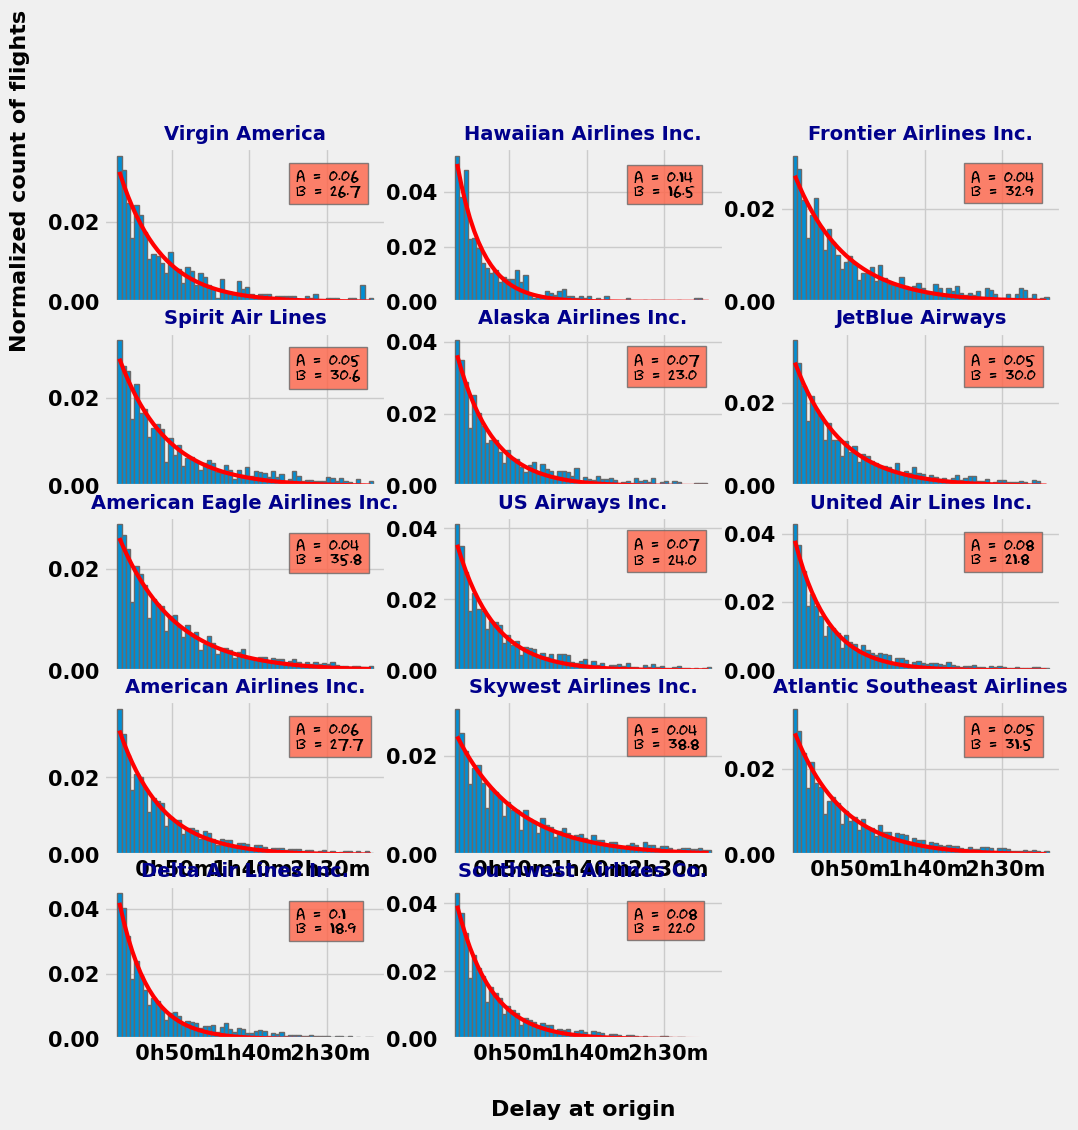

In [22]:
#___________________________________________
# Función del modelo utilizada para ajustar los histogramas
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)
    #_________________________
    # Ajuste de la distribución
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), density=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # Registro de los resultados
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # Dibuja la curva de ajuste
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)
    #_____________________________________
    # Define las etiquetas de los ejes para cada subgráfico
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # Título del subgráfico
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # Etiquetas de los ejes
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Leyenda: valores de los coeficientes a y b
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})

plt.tight_layout()

Esta figura muestra la distribución normalizada de los retrasos que modelamos con una distribución exponencial $ f(x) = a \, \mathrm{exp} (-x/b)$. Los parámetros
𝑎 y 𝑏 obtenidos para describir cada aerolínea se encuentran en la esquina superior derecha de cada panel. Cabe destacar que la normalización de la distribución implica que $\int f(x) \, dx \sim 1$. Aquí, no tenemos una igualdad estricta ya que la normalización se aplica a los histogramas pero no a la función del modelo. Sin embargo, esta relación implica que los coeficientes $a$ y $b$ estarán correlacionados con $a \propto 1/b$ ay por lo tanto, solo uno de estos dos valores es necesario para describir las distribuciones. Finalmente, según el valor de $a$ o $b$,  es posible establecer un ranking de las compañías: los valores bajos de $a$ corresponderán a aerolíneas con una gran proporción de retrasos importantes y, por el contrario, las aerolíneas que destacan por su puntualidad tendrán valores altos de $a$:

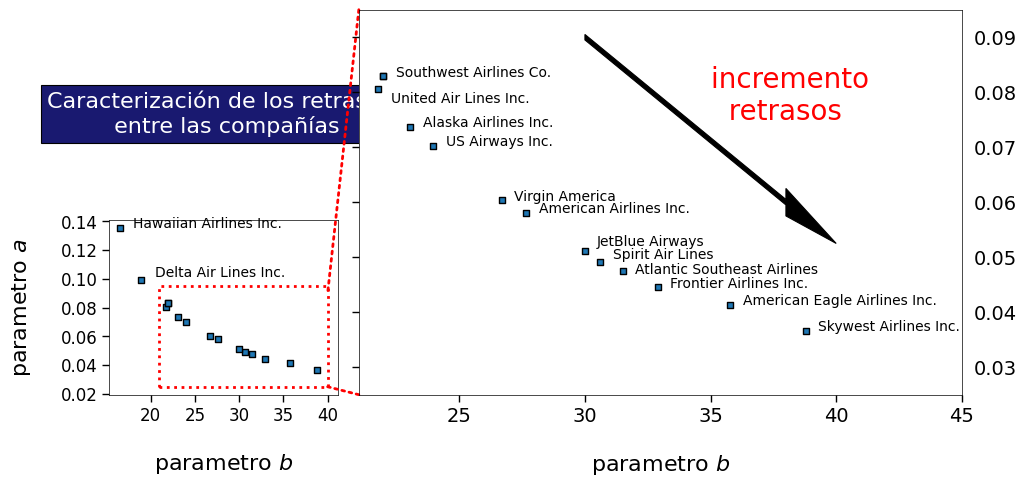

In [23]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

popt = [float(p) for p in popt]
points.append(popt)

points = [np.array(popt, dtype=float) for popt in points]


fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000


gs=GridSpec(2,7)
#_______________________________
ax1=fig.add_subplot(gs[1,0:2])

x_val = [float(p[1]) for p in points]
y_val = [float(p[0]) for p in points]

plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = 1)


#__________________________________
# Etiqueta de aerolinea
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("parametro $b$", fontsize=16, labelpad=20)
plt.ylabel("parametro $a$", fontsize=16, labelpad=20)
#__________________________________
# Etiqueta de aerolinea
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("parametro $b$", fontsize=16, labelpad=20)
plt.ylabel("parametro $a$", fontsize=16, labelpad=20)
#____________
# titulo principal
ax1.text(.5,1.5,'Caracterización de los retrasos \n entre las compañías', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# Parámetros de los bordes de la gráfica
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Creamos el rectangulo
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# Zoom en la mayoría de las aerolíneas (panel derecho)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = 1)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Etiquetas de aerolineas
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Dirección de incremento de los retrasos
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('incremento \n  retrasos', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# Posición y tamaño de las marcas (ticks)
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# Parámetros de los bordes de la gráfica
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')
#________________________________
# Conexión entre las 2 gráficas
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("parametro $b$", fontsize=16, labelpad=20)
plt.show()

El panel izquierdo de esta figura proporciona una visión general de los coeficientes $a$ y $b$ de las 14 aerolíneas, mostrando que Hawaiian Airlines y Delta Airlines ocupan los dos primeros lugares. El panel derecho hace un zoom en otras 12 aerolíneas. Podemos ver que SouthWest Airlines, que representa aproximadamente el 20% del número total de vuelos, está bien posicionada y ocupa la tercera posición. Según este ranking, SkyWest Airlines es la aerolínea peor clasificada.

___
## 3. Retrasos: ¿Despegue o aterrizaje ?
En la sección anterior, toda la discusión se centró en los retrasos en el despegue. Sin embargo, estos retrasos difieren en cierta medida de los retrasos registrados en la llegada:

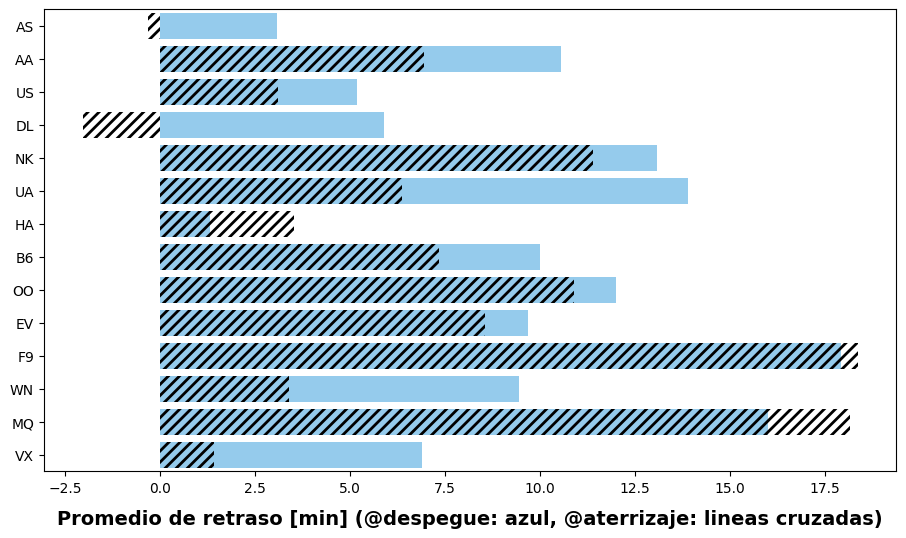

In [24]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)

labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Promedio de retraso [min] (@despegue: azul, @aterrizaje: lineas cruzadas)',
           fontsize=14, weight = 'bold', labelpad=10);
plt.show()

En esta figura, podemos ver que los retrasos en la llegada son generalmente menores que los retrasos en el despegue. Esto indica que las aerolíneas ajustan la velocidad de vuelo para reducir los retrasos en la llegada. A continuación, consideraremos únicamente los retrasos en el despegue, pero es importante tener en cuenta que estos pueden diferir de los retrasos en la llegada.

___
## 4. Relación entre el aeropuerto de origen y los retrasos

Ahora intentaremos definir si existe una correlación entre los retrasos registrados y el aeropuerto de origen. Recordemos que en el conjunto de datos, el número de aeropuertos considerados es:

In [25]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312




### 4.1 Área geográfica cubierta por las aerolíneas

Aquí, echaremos un vistazo rápido al número de aeropuertos de destino para cada aerolínea:

In [26]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

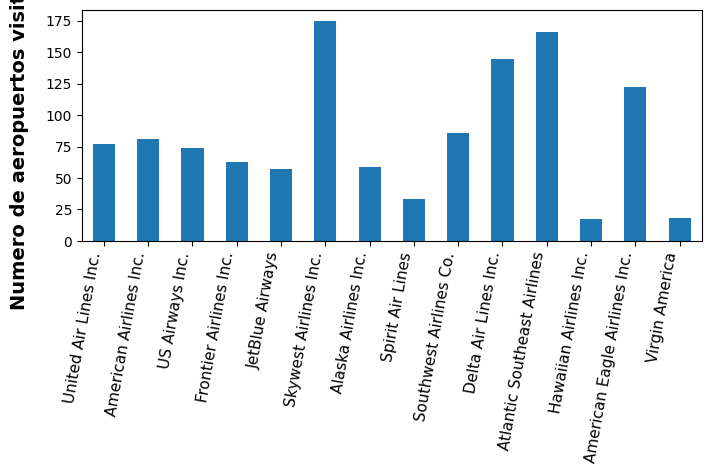

In [27]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Numero de aeropuertos visitados', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [28]:
# URL del archivo en Google Drive
url = 'https://drive.google.com/uc?id=16m4zG4-3UnUmerJIDYgP0SE2ebS7VNrI&export=download'
# Descargar el archivo CSV
output = 'airports.csv'
gdown.download(url, output, quiet=False)

temp = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=16m4zG4-3UnUmerJIDYgP0SE2ebS7VNrI&export=download
To: /content/airports.csv
100%|██████████| 23.9k/23.9k [00:00<00:00, 36.8MB/s]


___
### 4.2 Cómo impacta el aeropuerto de origen en los retrasos

En esta sección, examinaremos las variaciones de los retrasos con respecto al aeropuerto de origen y para cada aerolínea. El primer paso consiste en determinar los retrasos medios por aeropuerto:

In [29]:
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [30]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

Dado que el número de aeropuertos es bastante grande, un gráfico que muestre toda la información a la vez sería un poco confuso, ya que representaría alrededor de 4400 valores (es decir, 312 aeropuertos $\times$ 14 aerolíneas). Por lo tanto, solo representamos un subconjunto de los datos:

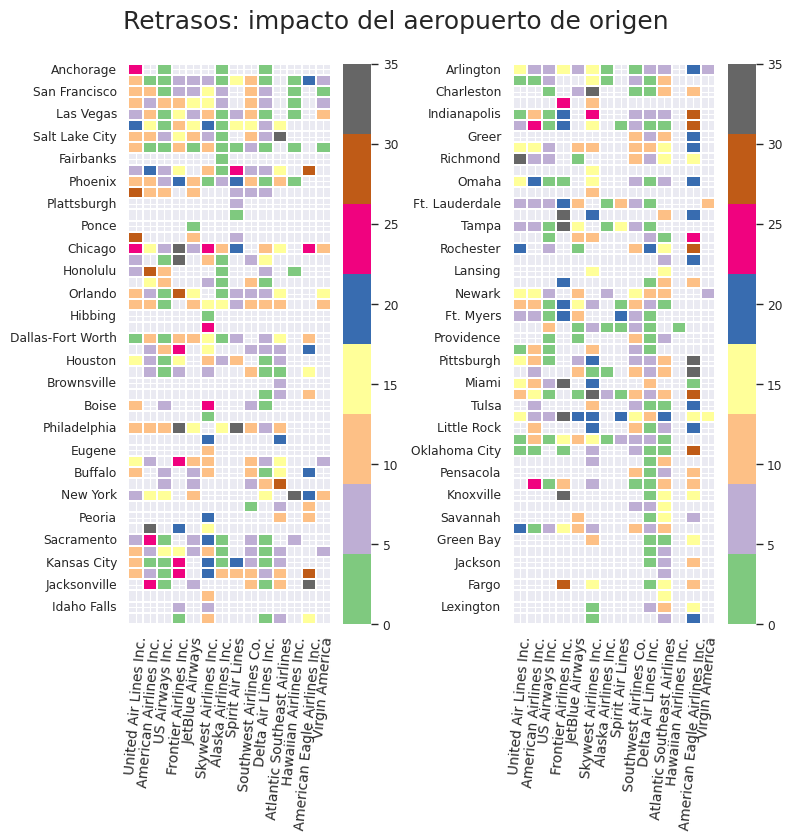

In [31]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Retrasos: impacto del aeropuerto de origen", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()
plt.show()

Esta figura permite sacar algunas conclusiones. Primero, al observar los datos asociados con las diferentes aerolíneas, encontramos el comportamiento que observamos anteriormente: por ejemplo, si consideramos el panel derecho, se verá que la columna asociada a American Eagle Airlines reporta principalmente grandes retrasos, mientras que la columna asociada a Delta Airlines está principalmente relacionada con retrasos de menos de 5 minutos. Si ahora miramos los aeropuertos de origen, veremos que algunos aeropuertos favorecen las salidas tardías: véase, por ejemplo, Denver, Chicago o Nueva York. Por el contrario, otros aeropuertos registran mayormente salidas puntuales, como Portland u Oakland.

Finalmente, podemos deducir de estas observaciones que hay una alta variabilidad en los retrasos promedio, tanto entre los diferentes aeropuertos como entre las diferentes aerolíneas. Esto es importante porque implica que, para modelar con precisión los retrasos, será necesario adoptar un modelo que sea específico para la compañía y el aeropuerto de origen.

___
### 4.3 ¿Vuelos con retrasos habituales?

En la sección anterior, se observó que existe variabilidad en los retrasos al considerar las diferentes aerolíneas y los diferentes aeropuertos de origen. Ahora voy a añadir un nivel de granularidad al centrarnos no solo en los aeropuertos de origen, sino en los vuelos específicos: origen $\to$ destino. El objetivo aquí es ver si algunos vuelos están sistemáticamente retrasados o si, por el contrario, hay vuelos que siempre llegan a tiempo.

A continuación, consideraremos el caso de una sola aerolínea. Enumeraremos todos los vuelos A $\to$ B realizados por esta compañía y, para cada uno de ellos, creamos la lista de retrasos que se han registrado:

In [32]:
#_________________________________________________________________
# Seleccionamos la compañía y creamos un subconjunto del dataframe principal
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# Reunimos las rutas y enumeramos los retrasos para cada una de ellas
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________
# Transponemos el diccionario a una lista para ordenar las rutas por aeropuertos de origen
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

Luego calculamos el retraso promedio en las diversas rutas  A $\to$ B, así como la desviación estándar, y una vez hecho esto, creamos una representación gráfica (para una muestra de los vuelos):


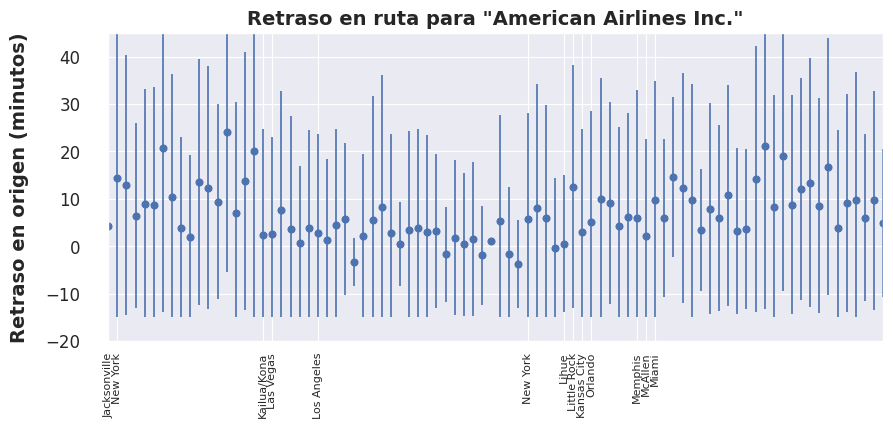

In [33]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # Definimos las etiquetas como el aeropuerto de origen.
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # Establecemos un umbral en los retrasos para evitar que los valores altos influyan demasiado.
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # Calculamos el promedio y las desviaciones estándar.
    mean_val.append(np.mean(trajet2))
    std_val.append(np.std(trajet2))
    i += 1
#________________
# Trazamos el gráfico.
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)]
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o')
ax.set_title('Retraso en ruta para "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Retraso en origen (minutos)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# Definimos el rango de los ejes x e y y las posiciones de los ticks.
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# Configuramos los parámetros de los ticks.
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

Esta figura muestra los retrasos promedio para American Airlines, según la ciudad de origen y el destino (notemos que en el eje de las abscisas, solo se indica el origen por claridad). Las barras de error asociadas con las diferentes rutas corresponden a las desviaciones estándar.

En este ejemplo, se puede ver que, para un aeropuerto de origen dado, los retrasos fluctuarán dependiendo del destino. Por ejemplo, aquí las mayores variaciones se obtienen para Nueva York o Miami, donde los retrasos promedio iniciales varían entre 0 y $\sim$20 minutos.

___
## 5. Variabilidad temporal de los retrasos

En esta sección, examino cómo varían los retrasos con el tiempo. Considerando el caso de una aerolínea y aeropuerto específicos, los retrasos pueden ser fácilmente representados por día y hora ( nota: antes de hacer esto, definimos una clase que utilizaremos extensamente en lo que sigue para producir gráficos):

In [34]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # Convertir self.axs a una matriz 2D
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])
    def show(self):
        plt.show()

In [35]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

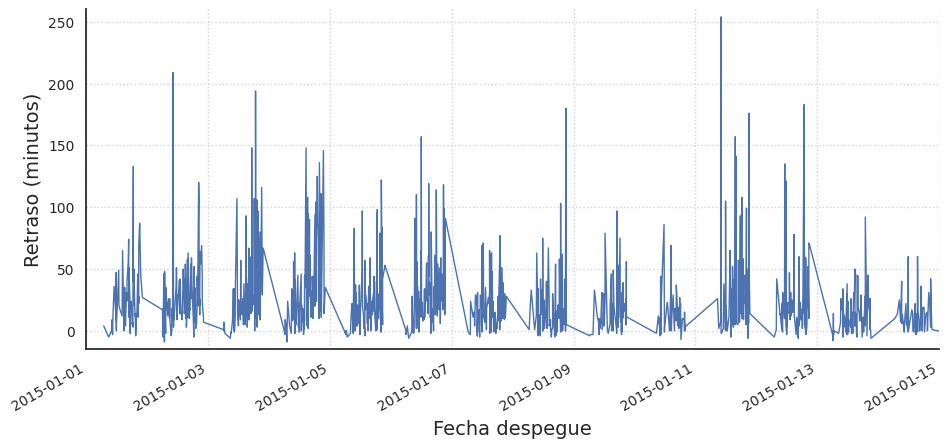

In [36]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style()
fig1.set_ylabel('Retraso (minutos)', fontsize = 14)
fig1.set_xlabel('Fecha despegue', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)
fig1.show()

Esta figura muestra la existencia de ciclos, tanto en la frecuencia de los retrasos como en su magnitud. De hecho, intuitivamente, parece bastante lógico observar tales ciclos, ya que serán una consecuencia de la alternancia día-noche y del hecho de que la actividad en el aeropuerto se reduce considerablemente (si no es que es inexistente) durante la noche. Esto sugiere que una **variable importante** en la modelización de los retrasos será **la hora de despegue**. Para verificar esta hipótesis, analizo el comportamiento del retraso promedio en función de la hora de despegue, agregando los datos del mes actual:

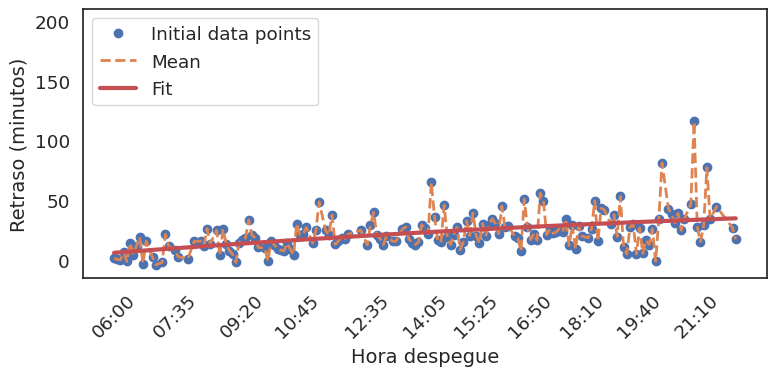

In [37]:
# Definición de la función cuadrática
def func2(x, a, b, c):
    return a * x**2 + b * x + c

# Conversión de 'SCHEDULED_DEPARTURE' a objetos datetime.time
df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x: x.time())

# Obtener estadísticas (asumiendo que get_stats devuelve un DataFrame con 'mean')
test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()

# Conversión de horas a segundos desde medianoche
fct = lambda x: x.hour * 3600 + x.minute * 60 + x.second
x_val = np.array([fct(s) for s in test2.index])
y_val = test2['mean']

# Ajuste de la función cuadrática a los datos
popt, pcov = curve_fit(func2, x_val, y_val, p0=[1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index=test2.index)

# Crear la figura y el gráfico
fig, ax = plt.subplots(figsize=(8, 4))

# Graficar los datos originales y el ajuste
ax.plot(x_val, y_val, 'o', label='Initial data points')
ax.plot(x_val, test2['mean'], linestyle='--', linewidth=2, label='Mean')
ax.plot(x_val, test2['fit'], color='r', linestyle='-', linewidth=3, label='Fit')

# Convertir los segundos de vuelta a formato de hora para las etiquetas
hours = np.array([f"{int(t // 3600):02}:{int((t % 3600) // 60):02}" for t in x_val])

# Ajustar etiquetas del eje x
ax.set_xticks(x_val[::len(x_val)//10])  # Ajusta según el tamaño del gráfico
ax.set_xticklabels(hours[::len(hours)//10], rotation=45)

# Configuración de etiquetas y leyenda
ax.set_ylabel('Retraso (minutos)', fontsize=14)
ax.set_xlabel('Hora despegue', fontsize=14)
ax.set_ylim(-15, 210)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Aquí, podemos ver que el retraso promedio tiende a aumentar con la hora de salida del día: los vuelos salen a tiempo en la mañana y el retraso crece casi de manera monótona hasta 30 minutos al final del día. De hecho, este comportamiento es bastante general y al observar otros aeropuertos o compañías, encontraríamos tendencias similares..

___
## 6. Predicción de retrasos de vuelos

Las secciones anteriores trataron la exploración del conjunto de datos. Aquí, empezamos con la modelización de los retrasos de vuelos. En esta sección, nuestro objetivo es crear un modelo que utilice una ventana de 3 semanas para predecir los retrasos de la semana siguiente. Por lo tanto, decidimos trabajar con los datos de enero con el objetivo de predecir los retrasos del período del $23^{\text{o}}$ al $31^{\text{o}}$ de enero

In [ ]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train
!pip install catboost
from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [ ]:
df_train

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0,0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0,0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0,0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0,0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
336190,B6,SMF,JFK,2015-01-22 23:59:00,00:05:00,6.0,08:10:00,08:21:00,11.0,311.0,316.0,1
336191,F9,DEN,ATL,2015-01-22 23:59:00,23:45:00,-14.0,04:41:00,04:41:00,0.0,162.0,176.0,0
336192,F9,DEN,TPA,2015-01-22 23:59:00,23:45:00,-14.0,05:11:00,05:02:00,-9.0,192.0,197.0,0
336193,UA,PHX,EWR,2015-01-22 23:59:00,23:48:00,-11.0,06:35:00,06:20:00,-15.0,276.0,272.0,0


### 6.3 Modelo nº3: Considerando los destinos

En el modelo anterior, agrupamos los vuelos por hora de salida. Por lo tanto, los vuelos con diferentes destinos se agruparon siempre que salieran a la misma hora. Ahora realizamos un modelo que tiene en cuenta tanto los horarios de salida como de llegada:



In [ ]:
def create_df(df, carrier):
    # Filtrar las filas del carrier y seleccionar las columnas necesarias
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                        'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how='any', inplace=True)

    # Añadir columna con el día de la semana
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x: x.weekday())

    # Eliminar filas con retrasos mayores a 60 minutos
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x: x if x < 60 else np.nan)
    df2.dropna(how='any', inplace=True)

    # Convertir las horas a segundos
    fct = lambda x: x.hour*3600 + x.minute*60 + x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x: fct(x.time()) if isinstance(x, pd.Timestamp) else fct(x))
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(lambda x: fct(x.time()) if isinstance(x, pd.Timestamp) else fct(x))

    return df2

# Preprocesamiento del dataframe
df3 = create_df(df, carrier='UA')  # Ajusta el carrier a tu caso

# Codificación de la columna categórica 'ORIGIN_AIRPORT'
label_encoder = LabelEncoder()
df3['ORIGIN_AIRPORT_ENC'] = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])

# Codificación one-hot de 'ORIGIN_AIRPORT_ENC'
onehot_encoder = OneHotEncoder(sparse=False)
airport_encoded = onehot_encoder.fit_transform(df3[['ORIGIN_AIRPORT_ENC']])

# Preparación de los datos para el modelo
X = np.hstack((airport_encoded, df3[['heure_depart', 'heure_arrivee', 'weekday']].values))
Y = df3['DEPARTURE_DELAY'].values.reshape(-1, 1)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
df3 = create_df(df, carrier)
df3

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,weekday,heure_depart,heure_arrivee
1,2015-01-01 00:10:00,07:50:00,LAX,PBI,-8.0,3,600,28200
3,2015-01-01 00:20:00,08:05:00,LAX,MIA,-5.0,3,1200,29100
8,2015-01-01 00:30:00,05:45:00,SFO,DFW,-11.0,3,1800,20700
11,2015-01-01 00:35:00,08:03:00,LAS,MIA,-8.0,3,2100,28980
21,2015-01-01 01:00:00,09:38:00,SEA,MIA,-8.0,3,3600,34680
...,...,...,...,...,...,...,...,...
336164,2015-01-22 23:49:00,00:49:00,MIA,MCO,-6.0,3,85740,2940
336169,2015-01-22 23:50:00,08:00:00,SFO,MIA,49.0,3,85800,28800
336170,2015-01-22 23:50:00,05:27:00,SEA,DFW,-4.0,3,85800,19620
336173,2015-01-22 23:54:00,05:50:00,LAX,ORD,-4.0,3,86040,21000


A partir de ahora, los reagrupamientos se realizan según las horas de salida y llegada, y los aeropuertos de origen y destino (específicos) se toman en cuenta de manera implícita. Como antes, realizo la codificación de los aeropuertos:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Función para crear un dataframe modificado
def create_df(df, carrier):
    # Filtrar las filas del carrier y seleccionar las columnas necesarias
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                        'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how='any', inplace=True)

    # Añadir columna con el día de la semana
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x: x.weekday())

    # Convertir retrasos en una clasificación binaria (0: no retraso, 1: retraso >= 15 minutos)
    df2['DELAY_CLASS'] = df2['DEPARTURE_DELAY'].apply(lambda x: 1 if x >= 15 else 0)

    # Convertir las horas a segundos
    fct = lambda x: x.hour*3600 + x.minute*60 + x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x: fct(x.time()) if isinstance(x, pd.Timestamp) else fct(x))
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(lambda x: fct(x.time()) if isinstance(x, pd.Timestamp) else fct(x))

    return df2

# Preprocesamiento del dataframe
df3 = create_df(df, carrier='UA')  # Ajusta el carrier a tu caso

# Codificación de la columna categórica 'ORIGIN_AIRPORT'
label_encoder = LabelEncoder()
df3['ORIGIN_AIRPORT_ENC'] = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])

# Codificación one-hot de 'ORIGIN_AIRPORT_ENC'
onehot_encoder = OneHotEncoder(sparse=False)
airport_encoded = onehot_encoder.fit_transform(df3[['ORIGIN_AIRPORT_ENC']])

# Preparación de los datos para el modelo
X = np.hstack((airport_encoded, df3[['heure_depart', 'heure_arrivee', 'weekday']].values))
Y = df3['DELAY_CLASS'].values  # Usamos la columna binaria DELAY_CLASS como objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear el modelo CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100)

# Entrenar el modelo
catboost_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Guardar predicciones en CSV
df3_test = df3.iloc[X_test[:, 0].astype(int)]
df3_test['Predicted_Delay_Class'] = y_pred
df3_test.to_csv('predicted_delay_classification.csv', index=False)

print("Archivo CSV con las predicciones guardado.")

0:	learn: 0.6663530	total: 14ms	remaining: 13.9s
100:	learn: 0.5372013	total: 1.25s	remaining: 11.1s
200:	learn: 0.5229230	total: 2.89s	remaining: 11.5s
300:	learn: 0.5119947	total: 4.37s	remaining: 10.2s
400:	learn: 0.5025369	total: 6.45s	remaining: 9.64s
500:	learn: 0.4939842	total: 8.35s	remaining: 8.32s
600:	learn: 0.4866154	total: 10.4s	remaining: 6.88s
700:	learn: 0.4797225	total: 12.2s	remaining: 5.2s
800:	learn: 0.4735861	total: 13.9s	remaining: 3.46s
900:	learn: 0.4682604	total: 15.8s	remaining: 1.73s
999:	learn: 0.4626612	total: 17.6s	remaining: 0us
Accuracy: 0.7256443063425334
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      3894
           1       0.56      0.23      0.32      1577

    accuracy                           0.73      5471
   macro avg       0.65      0.58      0.58      5471
weighted avg       0.69      0.73      0.68      5471

Archivo CSV con las predicciones guardado.


**Resultados Principales**

**Accuracy del Modelo:**

El modelo alcanzó una precisión global del 72.56%, lo que significa que casi el 73% de las predicciones realizadas por el modelo fueron correctas. Sin embargo, la precisión global (accuracy) puede no ser suficiente para comprender a fondo el rendimiento cuando se trata de un problema con clases desbalanceadas (más vuelos sin retraso que con retraso).

**Desempeño por Clases:**

El informe de clasificación detalla el rendimiento del modelo tanto para los vuelos sin retraso significativo (clase 0) como para los vuelos con retraso importante (clase 1):

**Para la clase 0 (vuelos sin retraso significativo)**, el modelo mostró un excelente desempeño con:

- Precisión de 0.75: De todos los vuelos que predijo sin retraso, el 75% realmente no tuvieron retraso.
- Recall de 0.93: De todos los vuelos que realmente no se retrasaron, el modelo identificó correctamente el 93%.
- F1-Score de 0.83: Indicando un equilibrio adecuado entre precisión y recall para esta clase.

**Para la clase 1 (vuelos con retraso significativo)**, el rendimiento fue menor:

- Precisión de 0.56: De los vuelos que el modelo predijo como retrasados, solo el 56% efectivamente tuvieron un retraso significativo.
- Recall de 0.23: El modelo solo identificó correctamente el 23% de los vuelos que realmente tuvieron un retraso.
- F1-Score de 0.32: Indicando que hay un desequilibrio considerable en la capacidad del modelo para manejar la predicción de retrasos.

## **Conclusiones**

**Buen rendimiento para vuelos sin retraso (clase 0):**
El modelo muestra una capacidad sólida para predecir vuelos que no tendrán retrasos significativos, con un recall alto (93%) y una buena precisión (75%). Esto significa que el modelo es confiable para identificar correctamente aquellos vuelos que no sufrirán retrasos.

**Desempeño limitado para vuelos con retraso significativo (clase 1):**
En cuanto a la predicción de retrasos importantes, el modelo tiene dificultades. El recall bajo (23%) indica que el modelo está subestimando la cantidad de vuelos que realmente experimentarán retrasos. La precisión (56%) tampoco es alta, lo que sugiere que muchas predicciones de retraso son incorrectas. En resumen, el modelo no es suficientemente preciso para detectar vuelos que se retrasarán.

Aunque el modelo también logra identificar vuelos con retrasos significativos, se pueden considerar mejoras para fortalecer la precisión en esta área. El 56% de precisión en la predicción de vuelos con retrasos indica que el modelo ofrece un buen punto de partida para detectar retrasos y puede ser ajustado para afinar su capacidad predictiva. Al utilizar técnicas adicionales de optimización, el modelo tiene el potencial de volverse más robusto en este aspecto y contribuir aún más a la planificación proactiva.